In [1]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import MWETokenizer

import csv
from gensim.models import Word2Vec
import os.path

plt.style.use('seaborn')
plt.style.use('seaborn-bright')
plt.style.use('seaborn-white')

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliisabethein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Functions

In [3]:
def load_data(filename, max_sentence_len, with_labels=False):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename, encoding="utf8") as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len, with_labels)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

In [4]:
def tokenize_sentence(string, max_sentence_len, with_labels=False, occurrences=None):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    if with_labels:
        sentence = sentence[1:]
    sentence = [token.lower() for token in sentence]            
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length    
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags
    if occurrences is not None:
        for word in sentence:
            if word in occurrences:
                occurrences[word] += 1
            else:
                occurrences[word] = 1

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    if occurrences is not None:
        return sentence, padded_sentence, occurrences
    else:
        return sentence, padded_sentence

In [5]:
def get_batches_text(data, data_padded, batch_size, pad_index, word2vec_model, unk_word='<unk>'):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index if word in word2vec_model.wv.vocab else word2vec_model.wv.vocab[unk_word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

def get_batches_synthetic(data, batch_size):
    inputs = []
    targets = []

    for i in range(len(data) // batch_size):
        batch_sentences = data[i * batch_size:(i+1) * batch_size]

        input_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        target_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        for j, sentence in enumerate(batch_sentences):
                input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
                target_batch[j,0:len(sentence)-1,0] = sentence[1:]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    return inputs, targets

### Encoder-decoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [7]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden
    

### VAE

In [8]:
class StochasticEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)

    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def forward(self, hidden_concatenated):
        mean = self.hidden_to_mean(hidden_concatenated)
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        return z, mean, log_variance

In [9]:
class StochasticDecoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
    def forward(self, z):
        hidden_concatenated = self.latent_to_hidden(z)
        return hidden_concatenated

In [10]:
# new VAE
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.stochastic_encoder = StochasticEncoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.stochastic_decoder = StochasticDecoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
        # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
        ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
        ## with this distribution it (kind of) works both without annealing and with annealing 
        ## (why??? who knows)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.encoder.embed.weight, -0.1, 0.1)
            nn.init.uniform_(self.decoder.embed.weight, -0.1, 0.1)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
    
    def latent_to_hidden(self, z):
        return self.stochastic_decoder.latent_to_hidden(z)
        
    # with teacher forcing
    def decode(self, hidden, x, x_lens=None, train=True): 
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None, dropout_rate=0, unk_index=0):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        z, mean, log_variance = self.stochastic_encoder.forward(hidden_concatenated)
        hidden_concatenated = self.stochastic_decoder.forward(z)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        
        # word dropout
        if dropout_rate != 0.0:
            drop_probs = np.random.random_sample(x.shape)
            drop_probs[:, 0] = 1                  # set the <sos> token to 1 (always keep)
            for i, x_len in enumerate(x_lens):
                drop_probs[i, x_len:, 0] = 1      # set the <pad> tokens to 1 (always keep)
            dropped_x = x.copy()
            dropped_x[drop_probs < dropout_rate] = unk_index
            outputs = self.decode(hidden, dropped_x, x_lens)
        else:
            outputs = self.decode(hidden, x, x_lens)
            
        return mean, log_variance, outputs
    
    def calc_mi(self, x):
        # I(x, z) = E_xE_{q(z|x)}log(q(z|x)) - E_xE_{q(z|x)}log(q(z))
        mean, log_variance, _ = self.forward(x)
        _, batch_size, _ = mean.size()

        # E_{q(z|x)}log(q(z|x)) = -0.5*nz*log(2*\pi) - 0.5*(1+logvar).sum(-1)
        neg_entropy = (-0.5 * self.latent_dim * np.log(2 * np.pi)- 0.5 * (1 + log_variance).sum(-1)).mean()

        z = self.stochastic_encoder.reparametrize(mean, log_variance)
        mean, log_variance = mean.unsqueeze(0), log_variance.unsqueeze(0)

        log_density = -0.5 * (((z - mean) ** 2) / log_variance.exp()).sum(dim=-1) - \
            0.5 * (self.latent_dim * np.log(2 * np.pi) + log_variance.sum(-1))

        log_qz = log_sum_exp(log_density, dim=1) - np.log(batch_size)

        return (neg_entropy - log_qz.mean(-1)).item()

In [11]:
def loss_function(outputs, labels, mean, log_variance, seq_length, annealing_args=None, mask=None):
    if mask is not None:
        BCE = torch.zeros(mean.shape[1] * (seq_length - 1))
        BCE[mask] = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    else:
        BCE = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    BCE = BCE.view(mean.shape[1], -1).sum(-1)
    KLD = -0.5 * (1 + log_variance - mean.pow(2) - log_variance.exp()).permute(1, 0, 2).sum(-1).squeeze(-1)
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    weighted_KLD = kl_weight * KLD
    loss = BCE + weighted_KLD
    return loss, BCE, KLD, weighted_KLD, kl_weight
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

In [12]:
def generate_interpolation_sequence(z1, z2, number_of_sentences_to_decode):
    interpolations = np.zeros((z1.shape[0], number_of_sentences_to_decode + 2))
    for dimension_of_z, (i, j) in enumerate(zip(z1, z2)):
        interpolations[dimension_of_z] = np.linspace(i, j, number_of_sentences_to_decode + 2)    
    return interpolations.T

### True posterior

In [13]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
        hidden_concatenated = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [29]:
def plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=3, iteration=None):
    latent_grid = generate_grid(-5, 5, step, latent_size)
    true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
    true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
    vae.eval()
    approximate_mean, _, _ = vae.forward(tracked_inputs)
    vae.train()
    plt.figure(figsize=(4,4))
    plt.plot(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100), color='silver', linestyle='dashed', linewidth=1.0, zorder=1)
    plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x', color='deepskyblue', s=15, zorder=2)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("true posterior mean")
    plt.ylabel("approximate posterior mean")
    plt.savefig("plots/mean_space_iteration_{}.pdf".format(iteration), bbox_inches="tight")
    plt.show()

def plot_kl(kl_terms, kl_weights):
    plot_step = 10
    x_axis = np.arange(len(kl_terms[::plot_step])) * plot_step
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(x_axis, kl_terms[::plot_step], label="KL term value")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("KL term")
    ax2 = ax1.twinx()
    ax2.plot(x_axis, kl_weights[::plot_step], color="orange", label="KL weight")
    ax2.set_ylabel("KL weight")
    ax2.set_ylim(0,1)
    plt.legend()
    plt.show()
    
def plot_losses(total_loss, ce_loss, kl_loss):
    plot_step = 10
    x_axis = np.arange(len(total_loss[::plot_step])) * plot_step
    total_loss = np.array(total_loss[::plot_step])
    kl_loss = np.array(kl_loss[::plot_step])
    fig, ax1 = plt.subplots(figsize=(8,4))
    plt.fill_between(x_axis, np.zeros(len(x_axis)), total_loss, label="total loss")
    plt.fill_between(x_axis, np.zeros(len(x_axis)), kl_loss, label="kl loss")
    plt.xlabel("loss")
    plt.ylabel("iteration")
    plt.legend()
    plt.show()

## Experiments

In [22]:
def train(vae, inputs, targets, validation_inputs, validation_targets, epochs, vocab_size, hidden_size, 
          latent_size, max_sentence_length, num_layers=1, learning_rate=0.001,
          synthetic=False, input_lens=None, val_input_lens=None,               # text-related parameters
          dropout_rate=0.0, unk_index = None,                                  # word dropout parameters
          plot=False, plot_lim=1.5, step=1.0, tracked_inputs=None, tracked_targets=None,      # plotting
          annealing_args=None, is_aggressive=False, verbose=True):
    
    opt_dict = {"not_improved": 0, "lr": learning_rate, "best_loss": 1e4}
    
    decay_epoch = 2
    lr_decay = 0.5
    max_decay = 5

#     enc_optimizer = torch.optim.SGD(vae.encoder.parameters(), lr=learning_rate)
#     stoch_enc_optimizer = torch.optim.SGD(vae.stochastic_encoder.parameters(), lr=learning_rate)
#     stoch_dec_optimizer = torch.optim.SGD(vae.stochastic_decoder.parameters(), lr=learning_rate)
#     dec_optimizer = torch.optim.SGD(vae.decoder.parameters(), lr=learning_rate)
    
    enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_enc_optimizer = torch.optim.Adam(vae.stochastic_encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_dec_optimizer = torch.optim.Adam(vae.stochastic_decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    
    if annealing_args is not None:
        kl_terms = []
        kl_weights = []

    iteration = decay_cnt = 0
    total_losses = []
    ce_losses = []
    kl_losses = []
    total_epoch_losses = []
    val_total_epoch_losses = []
    
    if plot:
        plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
    
    previous_mi = -1
        
    for epoch in range(epochs):        
        for i in np.random.permutation(len(inputs)):
            
            inner_iter = 1
            random_i = i
            
            burn_num_words = 0
            burn_pre_loss = 1e4
            burn_cur_loss = 0
            while is_aggressive and inner_iter < 100:
                x = inputs[random_i]
                y = torch.tensor(targets[random_i].reshape(-1), dtype=torch.long)
                x_lens = input_lens[random_i] if not synthetic else None
                
                enc_optimizer.zero_grad()
                stoch_enc_optimizer.zero_grad()
                stoch_dec_optimizer.zero_grad()
                dec_optimizer.zero_grad()
                
                if synthetic:
                    burn_batch_size, burn_sents_len, _ = x.shape
                    burn_num_words += burn_sents_len * burn_batch_size
                else:
                    burn_num_words = np.sum(x_lens)
                
                mask = None
                mean, log_variance, outputs = vae(x, x_lens=x_lens)
                if not synthetic:
                    mask = (y < padding_index)
                    outputs = outputs[mask]
                    y = y[mask]
    
                loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)
                
                loss = loss_summary[0]
                burn_cur_loss += loss.sum().item()
                
                loss = loss.mean(dim=-1)
                loss.backward()
                
                clip_grad_norm_(vae.parameters(), 5.0)
                
                stoch_enc_optimizer.step()
                enc_optimizer.step()
                
                random_i = np.random.randint(0, len(inputs)- 1)
                if inner_iter % 15 == 0:
                    burn_cur_loss = burn_cur_loss / burn_num_words
                    if burn_pre_loss - burn_cur_loss < 0:
                        break
                    burn_pre_loss = burn_cur_loss
                    burn_cur_loss = burn_num_words = 0
                inner_iter += 1
              
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None  
            
            mask = None
            mean, log_variance, outputs = vae(x, x_lens=x_lens, dropout_rate=dropout_rate, unk_index=unk_index)

            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]
            
            enc_optimizer.zero_grad()
            stoch_enc_optimizer.zero_grad()
            stoch_dec_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)
            
            total_losses.append(np.mean(loss_summary[0].data.numpy()))
            ce_losses.append(np.mean(loss_summary[1].data.numpy()))
            kl_losses.append(np.mean(loss_summary[3].data.numpy()))
            
            loss = loss_summary[0]
                
            loss = loss.mean(dim=-1)
            
            if annealing_args is not None:
                kl_terms.append(np.mean(loss_summary[2].data.numpy()))
                kl_weights.append(loss_summary[4])     
            
            loss.backward()
            clip_grad_norm_(vae.parameters(), 5.0)
            
            if not is_aggressive:
                stoch_enc_optimizer.step()
                enc_optimizer.step()
            
            dec_optimizer.step()
            stoch_dec_optimizer.step()

            if (iteration % 100 == 0) and verbose:
                print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f} weighted KL: {:.3f} weight {:.3f}'.format(epoch+1, 
                            iteration, loss, loss_summary[1].mean(dim=-1).data.item(), \
                            loss_summary[2].mean(dim=-1).data.item(), \
                            loss_summary[3].mean(dim=-1).data.item(), loss_summary[4]))

            iteration += 1
            
            if annealing_args is not None:
                annealing_args['step'] = iteration
        
        if is_aggressive:
            vae.eval()
            current_mi = calc_mi(vae, validation_inputs)
            vae.train()
            print('current_mi:', current_mi)
            if current_mi - previous_mi < 0:
                is_aggressive = False
                print("STOP AGGRESSIVE")

            previous_mi = current_mi
              
        # Validation
        vae.eval()
        with torch.no_grad():
            # NOTE!! if we want to do 100% dropout then we should also add it here.
            val_loss, val_kl, val_ppl = test_vae(vae, validation_inputs, validation_targets, val_input_lens, synthetic, annealing_args)
            loss, kl, ppl = test_vae(vae, inputs, targets, input_lens, synthetic, annealing_args)
            total_epoch_losses.append(loss)
            val_total_epoch_losses.append(val_loss)
            if verbose:
                print ('Epoch [{}/{}], Training Loss: {:.4f},  Training KL: {:.4f}, Training Perplexity: {:5.2f}, Validation Loss: {:.4f}, KL {:.4f}, Val Perplexity: {:5.2f}\n'
                       .format(epoch + 1, epochs, loss, kl, ppl, val_loss, val_kl, val_ppl))
            if plot:
                plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
                
            if val_loss > opt_dict["best_loss"]:
                opt_dict["not_improved"] += 1
                if opt_dict["not_improved"] >= decay_epoch:
                    opt_dict["best_loss"] = val_loss
                    opt_dict["not_improved"] = 0
                    opt_dict["lr"] = opt_dict["lr"] * lr_decay
                    #vae.load_state_dict(torch.load(args.save_path))
                    print('new lr: %f' % opt_dict["lr"])
                    decay_cnt += 1

#                     enc_optimizer = torch.optim.SGD(vae.encoder.parameters(), lr=opt_dict["lr"])
#                     stoch_enc_optimizer = torch.optim.SGD(vae.stochastic_encoder.parameters(), lr=opt_dict["lr"])
#                     stoch_dec_optimizer = torch.optim.SGD(vae.stochastic_decoder.parameters(), lr=opt_dict["lr"])
#                     dec_optimizer = torch.optim.SGD(vae.decoder.parameters(), lr=opt_dict["lr"])
                    
                    enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=opt_dict["lr"])
                    stoch_enc_optimizer = torch.optim.Adam(vae.stochastic_encoder.parameters(), lr=opt_dict["lr"])
                    stoch_dec_optimizer = torch.optim.Adam(vae.stochastic_decoder.parameters(), lr=opt_dict["lr"])
                    dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=opt_dict["lr"])
    
            else:
                opt_dict["not_improved"] = 0
                opt_dict["best_loss"] = val_loss
            
            if decay_cnt == max_decay:
                break
        vae.train()
    
    if annealing_args is not None and plot:
        plot_kl(kl_terms, kl_weights)
    if plot:
        plot_losses(total_losses, ce_losses, kl_losses)
        plt.plot(total_epoch_losses)
        plt.plot(val_total_epoch_losses)
        plt.show()
        
def test_vae(model, inputs, targets, input_lens, synthetic=False, annealing_args=None):
    kl_loss = ce_loss = 0
    num_words = num_sents = 0
    for i in np.random.permutation(len(inputs)):
        x = inputs[i]
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        x_lens = input_lens[i] if not synthetic else None

        batch_size, sents_len, _ = x.shape
        if synthetic:
            num_words += batch_size * sents_len
        else:
            num_words = np.sum(x_lens)
        
        num_sents += batch_size
        
        mask = None
        mean, log_variance, outputs = vae(x, x_lens=x_lens)
        if not synthetic:
            mask = (y < padding_index)
            outputs = outputs[mask]
            y = y[mask]

        loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)

        loss_rc = np.sum(loss_summary[1].data.numpy())
        loss_kl = np.sum(loss_summary[3].data.numpy())
        
        ce_loss += loss_rc.item()
        kl_loss += loss_kl.item()

    #mutual_info = calc_mi(model, test_data_batch)

    loss = (kl_loss + ce_loss) / num_sents
    kl = kl_loss / num_sents
    ppl = np.exp(loss * num_sents / num_words)

    return loss, kl, ppl

    
def calc_mi(model, test_data_batch):
    mi = 0
    num_examples = 0
    for batch_data in test_data_batch:
        batch_size = batch_data.shape[0]
        num_examples += batch_size
        mutual_info = model.calc_mi(batch_data)
        mi += mutual_info * batch_size

    return mi / num_examples

In [18]:
def hist_active_units(vae, train_inputs, train_lengths=None):
    all_mus = None
    for i in range(len(train_inputs)):
        mus, _ = vae.encode(train_inputs[i], train_lengths[i] if train_lengths is not None else None)
        mus = mus.squeeze(0)
        if all_mus is None:
            all_mus = mus.detach().numpy()
        else:
            all_mus = np.vstack((mus.detach().numpy(), all_mus))
    #print(np.sum(np.var(mus.detach().numpy(), axis=0) > 1e-2))
    plt.hist(np.var(mus.detach().numpy(), axis=0), bins=50)
    plt.show()

### Load Synthetic data

In [19]:
test_syn_data = np.loadtxt('synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('synthetic-data/synthetic_train.txt', dtype=int)

In [20]:
batch_size = 16

# load tracked inputs (for plotting)
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

# load data into batches
inputs, targets = get_batches_synthetic(train_syn_data, batch_size)
val_inputs, val_targets = get_batches_synthetic(test_syn_data, batch_size)

### Synthetic data

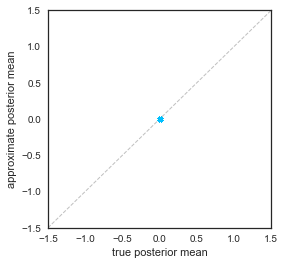

epoch 1 iteration 0 loss 62.174 CE 62.174 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 46.946 CE 46.946 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 200 loss 48.810 CE 48.810 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 300 loss 40.934 CE 40.933 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 400 loss 35.224 CE 35.221 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 1 iteration 500 loss 36.441 CE 36.439 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 600 loss 32.946 CE 32.946 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 700 loss 33.740 CE 33.739 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 800 loss 34.627 CE 34.627 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 900 loss 33.956 CE 33.955 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [1/30], Training Loss: 34.5224,  Training KL: 0.0002, Training Perplexity: 46.33, Validation Loss: 38.8493, KL 0.0002, Val Perplexity: 74.93



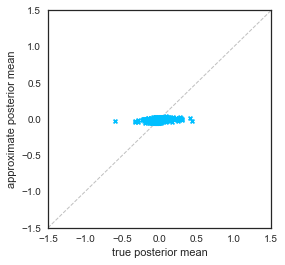

epoch 2 iteration 1000 loss 33.025 CE 33.024 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1100 loss 33.252 CE 33.251 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 2 iteration 1200 loss 36.115 CE 36.110 KL 0.005 weighted KL: 0.005 weight 1.000
epoch 2 iteration 1300 loss 32.930 CE 32.929 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 2 iteration 1400 loss 36.483 CE 36.481 KL 0.001 weighted KL: 0.001 weight 1.000


KeyboardInterrupt: 

In [30]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, val_inputs, val_inputs, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5, verbose=True)

In [ ]:
hist_active_units(vae, inputs)

In [ ]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 1.0
epochs = 10
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

In [ ]:
hist_active_units(vae, inputs)

In [ ]:
# aggresive training
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5, is_aggressive=True)

In [ ]:
hist_active_units(vae, inputs)

### Interpolate

# TEXT DATA

### Load Penn Treebank data

In [ ]:
max_sentence_length = 50
train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

In [ ]:
embedding_size = 500
epochs_w2v = 100

word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=epochs_w2v, total_examples=word2vec_model.corpus_count)

word2vec_model = Word2Vec.load("word2vec.model")
# print(word2vec_model.wv.most_similar("stocks"))
# word2vec_model.wv['credit']

vocabulary_size = len(word2vec_model.wv.vocab)
# print("size of the vocabulary:", vocabulary_size)
# word2vec_model.save("word2vec.model")

In [ ]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [ ]:
batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

In [ ]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 2
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 1

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=False)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, plot=False, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

### Inference/Generation/Interpolation

In [ ]:
def generate(vae, z, first_word_index, last_word_index, max_sentence_length):
    generator_batch_size = z.shape[0]
    hidden_concatenated = vae.stochastic_decoder.forward(z)
    hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
    generated_sequence = greedy(vae, hidden, first_word_index, last_word_index, max_sentence_length, generator_batch_size)
    return generated_sequence

def greedy(vae, hidden, first_word_index, last_word_index, max_sentence_length, generator_batch_size):
    vae_decoder = vae.decoder   
    first_word_index = torch.tensor(first_word_index, dtype=torch.long)
    predicted = []
    curr_words = torch.tensor([first_word_index] * generator_batch_size, dtype=torch.long).unsqueeze(1)
    iteration = 0
    while iteration != max_sentence_length: #next_word_index != last_word_index and
        curr_words_embeddings = vae_decoder.embed(curr_words)
        curr_words_embeddings = curr_words_embeddings.view(generator_batch_size, 1, vae_decoder.embedding_size)
        
        outputs, hidden = vae_decoder.lstm(curr_words_embeddings.float(), (hidden[0].unsqueeze(0), hidden[1].unsqueeze(0)))
        outputs = vae_decoder.linear(outputs)
        outputs = outputs.squeeze(1)
        hidden = (hidden[0].squeeze(0), hidden[1].squeeze(0))
        softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
    
        next_words_indices = []
        for t in range(generator_batch_size):
            
            # IS THE NEXT LINE OK? DO INDICES MATCH PROBABILITES?            
            
            next_words_indices.append(np.random.choice(np.arange(softmax_outputs.shape[1]), size=1, p=softmax_outputs[t])[0])        
        curr_words = torch.tensor(next_words_indices, dtype=torch.long).unsqueeze(1)
                
        predicted.append(next_words_indices)

        iteration += 1
        
#     if predicted[-1] != last_word_index:
#         predicted.append(last_word_index)
    return predicted

In [ ]:
z1 = torch.randn([latent_size]).numpy()
z2 = torch.randn([latent_size]).numpy()
number_of_sentences_to_decode = 2
max_sentence_length = 10
interpolation_points = generate_interpolation_sequence(z1, z2, number_of_sentences_to_decode=number_of_sentences_to_decode)

sentences = generate(vae, torch.tensor(interpolation_points, dtype=torch.float), word2vec_model.wv.vocab['<sos>'].index, word2vec_model.wv.vocab['<eos>'].index, max_sentence_length)
words_sentences = []
sentences = np.array(sentences).T
for curr_sentence in sentences:
    words_curr_sentence = []
    for j in curr_sentence:
        words_curr_sentence.append(word2vec_model.wv.index2word[j])
    words_sentences.append(words_curr_sentence)
for s in words_sentences:
    for word in s:
        print(word, end = ' ')
    print()

### Create Word2Vec word embeddings

### Define RNNLM

In [ ]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train and predict with RNNLM

In [ ]:
input_size = 100
output_size = 100
hidden_size = 50

batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

learning_rate = 0.001
num_layers = 1
epochs = 100

model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

In [ ]:
# Predict
test_sentences = ["in terms"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]

predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

### Yelp data

In [ ]:
max_sentence_len = 50
yelp_train_data_original, yelp_train_data_padded = load_data("yelp_data/yelp.train.txt", max_sentence_len, with_labels=True)
yelp_test_data_original, yelp_test_data_padded = load_data("yelp_data/yelp.test.txt", max_sentence_len, with_labels=True)
yelp_val_dat_original, yelp_val_data_padded = load_data("yelp_data/yelp.valid.txt", max_sentence_len, with_labels=True)

In [ ]:
embedding_size = 512
epochs_w2v = 100
word2vec_model_name = "word2vec_yelp.model"

if os.path.isfile(word2vec_model_name):
    print('Loading word2vec model:', word2vec_model_name)
    word2vec_yelp = Word2Vec.load(word2vec_model_name)
else:
    print('Training word2vec model')
    word2vec_yelp = Word2Vec(yelp_train_data_original, min_count=1, size=embedding_size, window=5)
    word2vec_yelp.train(yelp_train_data_original, epochs=epochs_w2v, total_examples=word2vec_yelp.corpus_count)
    word2vec_yelp.save(word2vec_model_name)
    print('Saved word2vec model:', word2vec_model_name)

In [ ]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_yelp.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [ ]:
print(word2vec_yelp.wv.most_similar("coffee"))

In [ ]:
batch_size = 16
vocabulary_size = len(word2vec_yelp.wv.vocab)
padding_index = vocabulary_size

yelp_train_inputs, yelp_train_targets, yelp_train_lengths = \
                get_batches_text(yelp_train_data_original, yelp_train_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

yelp_test_inputs, yelp_test_targets, yelp_test_lengths = \
                get_batches_text(yelp_test_data_original, yelp_test_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

yelp_val_inputs, yelp_val_targets, yelp_val_lengths = \
                get_batches_text(yelp_val_dat_original, yelp_val_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

In [ ]:
hidden_size = 1024
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 5

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, yelp_train_inputs[:], yelp_train_targets[:], yelp_val_inputs, yelp_val_targets, epochs, vocabulary_size, 
      hidden_size, latent_size, max_sentence_length, yelp_train_lengths[:], plot=False, learning_rate=learning_rate,
      synthetic=False, step=step, tracked_inputs=None, tracked_targets=None, plot_lim=1.5)

## ENCODER-DECODER BASELINE

In [ ]:
class Baseline(nn.Module):
    # just a basic encoder-decoder with no VAE layers in the middle
    def __init__(self, hidden_dim, num_layers, embedding_weights, synthetic=False):
        super(Baseline, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)

        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.encoder.embed.weight, -0.1, 0.1)
            nn.init.uniform_(self.decoder.embed.weight, -0.1, 0.1)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
        
    def decode(self, hidden, x, x_lens=None, train=True): 
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None):
        # the last hidden state of the encoder is the first hidden state of the decoder
        hidden = self.encode(x, x_lens)
#         hidden_concatenated = self.stochastic_decoder.forward(z)
#         hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return outputs

In [ ]:
def baseline_loss_function(outputs, labels, seq_length, batch_size, mask=None):
    if mask is not None:
        BCE = torch.zeros(batch_size * (seq_length - 1))
        BCE[mask] = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    else:
        BCE = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    BCE = BCE.view(batch_size, -1).sum(-1)
    return BCE

In [ ]:
def test_baseline(model, inputs, targets, input_lens, synthetic=False):
    total_loss = 0
    num_words = num_sents = 0
    for i in np.random.permutation(len(inputs)):
        x = inputs[i]
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        x_lens = input_lens[i] if not synthetic else None

        batch_size, sents_len, _ = x.shape
        if synthetic:
            num_words += batch_size * sents_len
        else:
            num_words = np.sum(x_lens)
        num_sents += batch_size
        
        mask = None
        outputs = model(x, x_lens=x_lens)
        if not synthetic:
            mask = (y < padding_index)
            outputs = outputs[mask]
            y = y[mask]
        curr_loss = baseline_loss_function(outputs, y, max_sentence_length, batch_size, mask=mask)
        curr_loss = np.sum(curr_loss.data.numpy())
        total_loss += curr_loss.item()
    
    total_loss /= num_sents
    ppl = np.exp(total_loss * num_sents / num_words)
    return total_loss, ppl

In [ ]:
def train_baseline(model, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                   max_sentence_length, input_lens=None, val_input_lens=None, synthetic=False, 
                   num_layers=1, learning_rate=0.001, verbose_level=1, plot=False):

    opt_dict = {"not_improved": 0, "lr": learning_rate, "best_loss": 1e4}
    decay_epoch = 2
    lr_decay = 0.5
    max_decay = 5
    decay_cnt = 0
    
    enc_optimizer = torch.optim.SGD(model.encoder.parameters(), lr=learning_rate)
    dec_optimizer = torch.optim.SGD(model.decoder.parameters(), lr=learning_rate)

    iteration = 0
    train_losses = []
    val_losses = []
            
    for epoch in range(epochs):        
        for i in np.random.permutation(len(inputs)):
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None 
          
            batch_size, _, _ = x.shape
            mask = None
            # do the forward pass
            outputs = model(x, x_lens=x_lens)

            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]
            
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            # compute the cross entropy loss
            loss = baseline_loss_function(outputs, y, max_sentence_length, batch_size, mask=mask)                
            loss = loss.mean(dim=-1) # take the mean (same as divide by batch size?)
            
            # backward pass
            loss.backward()
            clip_grad_norm_(model.parameters(), 5.0)
            enc_optimizer.step()
            dec_optimizer.step()
            
            if (iteration % 100 == 0) and (verbose_level == 2):
                print('epoch {}\titeration {}\ttraining loss {:.3f}'.format(epoch+1, iteration, loss))

            iteration += 1
              
        # evaluate on the validation data
        model.eval()
        with torch.no_grad():
            train_loss, train_ppl = test_baseline(model, inputs, targets, input_lens, synthetic)
            val_loss, val_ppl = test_baseline(model, val_inputs, val_targets, val_input_lens, synthetic)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            if verbose_level > 0:
                print ('Epoch [{}/{}], Training Loss: {:.4f} Perplexity: {:.4f}, Validation Loss: {:.4f} Perplexity {:.4f}'
                       .format(epoch+1, epochs, train_loss, train_ppl, val_loss, val_ppl))

            # are we still decaying with the same logic?
            if val_loss > opt_dict["best_loss"]:
                opt_dict["not_improved"] += 1
                if opt_dict["not_improved"] >= decay_epoch:
                    opt_dict["best_loss"] = val_loss
                    opt_dict["not_improved"] = 0
                    opt_dict["lr"] = opt_dict["lr"] * lr_decay
                    #vae.load_state_dict(torch.load(args.save_path))
                    print('new lr: %f' % opt_dict["lr"])
                    decay_cnt += 1

                    enc_optimizer = torch.optim.SGD(model.encoder.parameters(), lr=opt_dict["lr"])
                    dec_optimizer = torch.optim.SGD(model.decoder.parameters(), lr=opt_dict["lr"])
            else:
                opt_dict["not_improved"] = 0
                opt_dict["best_loss"] = val_loss
            
            if decay_cnt == max_decay:
                break
        model.train()
    
    if plot:
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.show()

In [ ]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
num_layers = 1
learning_rate = 1.0
epochs = 20
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
baseline_model = Baseline(hidden_size, num_layers, embedding_weights, synthetic=True)

# verbose level 0 - print nothing
# verbose level 1 - print only at the end of each epoch
# verbose level 2 - print everything
verbose_level = 1

train_baseline(baseline_model, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, max_sentence_length, 
               learning_rate=learning_rate, synthetic=True, verbose_level=verbose_level, plot=True)

## Word dropout

In [ ]:
max_sentence_length = 50
train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

In [ ]:
embedding_size = 512
epochs_w2v = 100

word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=epochs_w2v, total_examples=word2vec_model.corpus_count)

# word2vec_model = Word2Vec.load("word2vec.model")
# print(word2vec_model.wv.most_similar("stocks"))
# word2vec_model.wv['credit']

vocabulary_size = len(word2vec_model.wv.vocab)
# print("size of the vocabulary:", vocabulary_size)
# word2vec_model.save("word2vec.model")

In [ ]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [ ]:
batch_size = 32
# use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data, train_data_padded, batch_size, padding_index, word2vec_model)
val_batches, val_targets, val_sentence_lens = get_batches_text(val_data, val_data_padded, batch_size, padding_index, word2vec_model)

In [ ]:
hidden_size = 1024
latent_size = 13
num_layers = 1
learning_rate = 0.01
epochs = 10

# dropout rate 80%
unk_index = word2vec_model.wv.vocab["<unk>"].index
dropout_prob = 0.8

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=False)

train(vae, train_batches, train_targets, val_batches, val_targets, epochs, vocab_size, hidden_size, latent_size, 
      max_sentence_length, plot=False, verbose=True, learning_rate=learning_rate, synthetic=False,
      input_lens=train_sentence_lens, val_input_lens=val_sentence_lens, unk_index=unk_index, dropout_rate=dropout_prob)